<a href="https://colab.research.google.com/github/dipta007/Movie-Recommendation/blob/single-label-classification/Movie_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
from os.path import join
import os

ROOT = '/content/drive'     # default for the drive
PROJ = 'My Drive/Colab_data/MR1'       # path to your project on Drive
drive.mount(ROOT)           # we mount the drive at /content/drive

PROJECT_PATH = join(ROOT, PROJ)
!mkdir "{PROJECT_PATH}"    # in case we haven't created it already   
%cd "{PROJECT_PATH}"
%ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
mkdir: cannot create directory ‘/content/drive/My Drive/Colab_data/MR1’: File exists
/content/drive/My Drive/Colab_data/MR1
data/  multilayer_perceptron_graph.png


In [3]:
%matplotlib inline
import numpy as np
import pandas as pd

DATA_PATH = './data/ml-latest-small'

ratings = pd.read_csv(f"{DATA_PATH}/ratings.csv")
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
movies = pd.read_csv(f"{DATA_PATH}/movies.csv")
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

user_enc = LabelEncoder()
ratings['user'] = user_enc.fit_transform(ratings['userId'].values)
n_users = ratings['user'].nunique()

movie_enc = LabelEncoder()
ratings['movie'] = movie_enc.fit_transform(ratings['movieId'].values)
n_movies = ratings['movie'].nunique()

ratings['rating'] = ratings['rating'].values.astype(np.float32)
min_rating = min(ratings['rating'])
max_rating = max(ratings['rating'])

# n_users, n_movies, min_rating, max_rating
# del ratings['timestamp']
ratings.head()
ratings.shape

(100836, 6)

In [7]:
# Delete all the rows with less ratings
indexes = ratings[ ratings.rating < 3.5 ].index
nratings = ratings.drop(indexes)
nratings.shape

(61716, 6)

In [0]:
user_movie_count = [0 for _ in range(n_users)]
user_movie = {}
for index, row in nratings.iterrows():
  now = int(row.user)
  user_movie_count[now] += 1
  if now not in user_movie:
    user_movie[now] = []
  user_movie[now].append(row.movie)

MIN_NUMBER_OF_MOVIES = 4

In [12]:
MIN_NUMBER_OF_MOVIES, n_users, n_movies, min_rating, max_rating

(4, 610, 9724, 0.5, 5.0)

In [0]:
def convert_to_one_hot(movie):
  now = [0 for _ in range(n_movies)]
  now[int(movie)] = 1.0
  return now

prev_movies = []
next_movies = []
for user in range(n_users):
  if user not in user_movie:
    continue
  for i in range(len(user_movie[user]) - MIN_NUMBER_OF_MOVIES):
    now_movies = user_movie[user]
    
    # Previous movies he has saw already
    prev_movies.append(now_movies[i:i+MIN_NUMBER_OF_MOVIES]);

    # Next movies he should see
    next_movies.append(convert_to_one_hot(now_movies[i+MIN_NUMBER_OF_MOVIES]));


In [18]:
len(prev_movies), len(next_movies)

(59286, 59286)

In [19]:
prev_movies[0], len(next_movies[0])

([0.0, 2.0, 5.0, 43.0], 9724)

In [0]:
X = np.array(prev_movies).reshape(len(prev_movies), 4, 1)
Y = np.array(next_movies)
X.shape, Y.shape

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=47)

In [23]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((47428, 4, 1), (11858, 4, 1), (47428, 9724), (11858, 9724))

In [0]:
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam, RMSprop
from keras.regularizers import l2
from keras.layers import Concatenate, Dense, Dropout, Activation, Lambda, LSTM

def Model1(n_users, n_movies):
  input1 = Input(shape=(MIN_NUMBER_OF_MOVIES, 1,))
  x = LSTM(128)(input1)
  x = Dense(1000)(x)
  x = Dense(n_movies)(x)
  x = Activation('softmax')(x)

  model = Model(inputs=input1, outputs=x)
  # rms = RMSprop(lr=0.001)
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  
  # model.compile(loss='mean_squared_error', optimizer=rms, metrics=['accuracy'])
  return model

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 4, 1)              0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dense_2 (Dense)              (None, 1000)              129000    
_________________________________________________________________
dense_3 (Dense)              (None, 9724)              9733724   
_________________________________________________________________
activation_2 (Activation)    (None, 9724)              0         
Total params: 9,929,284
Trainable params: 9,929,284
Non-trainable params: 0
_________________________________________________________________


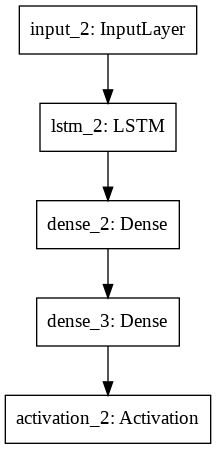

In [32]:
model = Model1(n_users, n_movies)
model.summary()

# from keras.utils import plot_model
# plot_model(model, to_file='multilayer_perceptron_graph.png')

In [33]:
history = model.fit(x=X, y=Y, batch_size=64, epochs=5, verbose=1, 
                    validation_data=(X_test, y_test))

Train on 59286 samples, validate on 11858 samples
Epoch 1/5
59286/59286 [==============================] - 50s 851us/step - loss: 7.2372 - accuracy: 0.0179 - val_loss: 6.4943 - val_accuracy: 0.0262
Epoch 2/5
59286/59286 [==============================] - 48s 815us/step - loss: 6.3729 - accuracy: 0.0308 - val_loss: 6.0445 - val_accuracy: 0.0255
Epoch 3/5
59286/59286 [==============================] - 49s 822us/step - loss: 6.0675 - accuracy: 0.0371 - val_loss: 5.7949 - val_accuracy: 0.0406
Epoch 4/5
59286/59286 [==============================] - 49s 822us/step - loss: 5.8862 - accuracy: 0.0408 - val_loss: 5.7361 - val_accuracy: 0.0374
Epoch 5/5
59286/59286 [==============================] - 49s 820us/step - loss: 5.7673 - accuracy: 0.0443 - val_loss: 5.5882 - val_accuracy: 0.0451


In [0]:
nolan = movie_enc.transform([109487, 33794, 33794, 74458])

In [35]:
res = model.predict(nolan.reshape(1, 4, 1))
np.argmax(res)

6993

In [36]:
movie_enc.inverse_transform([226])

array([262])

In [0]:
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.layers import Concatenate, Dense, Dropout, Activation, Lambda

def RecommenderV1(n_users, n_movies, n_factors):
    user = Input(shape=(1,))
    u = Embedding(n_users, n_factors, embeddings_initializer='he_normal', embeddings_regularizer=l2(1e-6))(user)
    u = Reshape((n_factors,))(u)
    
    movie = Input(shape=(1,))
    m = Embedding(n_movies, n_factors, embeddings_initializer='he_normal', embeddings_regularizer=l2(1e-6))(movie)
    m = Reshape((n_factors,))(m)
    
    x = Concatenate()([u, m])
    x = Dropout(0.2)(x)

    x = Dense(100, kernel_initializer='he_normal', activation="relu")(x)
    x = Dropout(0.2)(x)

    x = Dense(50, kernel_initializer='he_normal', activation="relu")(x)
    x = Dropout(0.2)(x)

    x = Dense(20, kernel_initializer='he_normal', activation="relu")(x)
    x = Dropout(0.2)(x)

    x = Dense(10, kernel_initializer='he_normal', activation="relu")(x)
    x = Dropout(0.2)(x)
    
    x = Dense(1, kernel_initializer='he_normal', activation="sigmoid")(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)

    model = Model(inputs=[user, movie], outputs=x)
    adam = Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=adam)
    return model

In [29]:
model = RecommenderV1(n_users, n_movies, n_factors)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 1, 50)        30500       input_9[0][0]                    
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 1, 50)        486200      input_10[0][0]                   
____________________________________________________________________________________________

In [30]:
history = model.fit(x=X_train_array, y=y_train, batch_size=64, epochs=5, 
                    verbose=1, validation_data=(X_test_array, y_test))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 90752 samples, validate on 10084 samples
Epoch 1/5
90752/90752 [==============================] - 12s 134us/step - loss: 0.8969 - val_loss: 0.7520
Epoch 2/5
90752/90752 [==============================] - 12s 129us/step - loss: 0.7486 - val_loss: 0.7314
Epoch 3/5
90752/90752 [==============================] - 12s 133us/step - loss: 0.7005 - val_loss: 0.7349
Epoch 4/5
90752/90752 [==============================] - 12s 129us/step - loss: 0.6697 - val_loss: 0.7289
Epoch 5/5
90752/90752 [==============================] - 12s 134us/step - loss: 0.6431 - val_loss: 0.7438


In [0]:
def 